

## PyTorch Speech Recognition Challenge

https://www.kaggle.com/c/tensorflow-speech-recognition-challenge


Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>


#### References:

- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- https://www.bountysource.com/issues/44576966-a-tutorial-on-writing-custom-datasets-samplers-and-using-transforms

- https://medium.com/towards-data-science/my-first-kaggle-competition-9d56d4773607

- https://github.com/sohyongsheng/kaggle-planet-forest

- https://github.com/rwightman/pytorch-planet-amazon/blob/master/dataset.py


## PyTorch dada sets

- Convert the audio files into images (spectogram) 
- Create a CSV file consisting of the good labels 
- Then write a custom PyTorch data loader
- Simple CNN

## Issues:
- Problem with the loss function for the multi-class case during training, loss is negative

# PyTorch Imports


In [77]:
% reset -f
import torch
import sys
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

import numpy
import numpy as np

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

import pandas
import pandas as pd

import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil
import os
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()

__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.2.1+a4fc05a
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2016 NVIDIA Corporation
Built on Mon_Jan__9_17:32:33_CST_2017
Cuda compilation tools, release 8.0, V8.0.60
__CUDNN VERSION: None
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
1.9
svmem(total=68627443712, available=38805884928, percent=43.5, used=29821558784, free=38805884928)
memory GB: 1.7805747985839844


In [78]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# Setting up global variables

- Root folder
- Audio folder
- Audio Label folder

In [79]:
DATA_ROOT ='d:/db/data/tf/'
IMG_PATH = DATA_ROOT + '/picts/train/'
IMG_EXT = '.png'
IMG_DATA_LABELS = DATA_ROOT + '/train_v2.csv'

# Turn WAV into Images
- See https://www.kaggle.com/timolee/audio-data-conversion-to-images-eda


In [80]:
audio_path = 'd:/db/data/tf/train/audio/'
pict_Path = 'd:/db/data/tf//picts/train/'
test_pict_Path = 'd:/db/data/tf//picts/test/'
test_audio_path = 'd:/db/data/tf//test/audio/'
samples = []


if not os.path.exists(pict_Path):
    os.makedirs(pict_Path)

if not os.path.exists(test_pict_Path):
    os.makedirs(test_pict_Path)
    
subFolderList = []

for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)
        if not os.path.exists(pict_Path + '/' + x):
            os.makedirs(pict_Path +'/'+ x)

In [81]:
# #### Function: convert audio to spectogram images

# def wav2img(wav_path, targetdir='', figsize=(4,4)):
#     """
#     takes in wave file path
#     and the fig size. Default 4,4 will make images 288 x 288
#     """
#     fs = 44100 # sampling frequency
    
#     # use soundfile library to read in the wave files
#     test_sound, samplerate = sf.read(wav_path)
    
#     # make the plot
#     fig = plt.figure(figsize=figsize)
#     S, freqs, bins, im = plt.specgram(test_sound, NFFT=1024, Fs=samplerate, noverlap=512)
#     plt.show
#     plt.axis('off')
    
#     ## create output path
#     output_file = wav_path.split('/')[-1].split('.wav')[0]
#     output_file = targetdir +'/'+ output_file
#     plt.savefig('%s.png' % output_file)
#     plt.close()


# def wav2img_waveform(wav_path, targetdir='', figsize=(4,4)):
#     test_sound, samplerate = sf.read(sample_audio[0])
#     fig = plt.figure(figsize=figsize)
#     plt.plot(test_sound)
#     plt.axis('off')
#     output_file = wav_path.split('/')[-1].split('.wav')[0]
#     output_file = targetdir +'/'+ output_file
#     plt.savefig('%s.png' % output_file)
#     plt.close()

# ### Convert Training Audio
# #### Loop through source audio and save as pictures 
# # (may take a while) may also consider running at commandline. 
# # Code is limited to 3 folders and 10 files each, get rid of array limits to process the entire directory

# # c:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7221: RuntimeWarning: divide by zero encountered in log10
# #   Z = 10. * np.log10(spec)

# for i, x in enumerate(subFolderList):
#     print(i, ':', x)
#     # get all the wave files
#     all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
#     for file in all_files:
#         try:
#             wav2img(audio_path + x + '/' + file, pict_Path + x)                
#         except Exception:
#             pass
            

# Generate lables into a CSV, which is easier for PyTorch Dataset class

In [86]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Build the pictures path
subFolderList = []
for x in os.listdir(pict_Path):
    if os.path.isdir(pict_Path + '/' + x):
        subFolderList.append(x)        
            
good_labels=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()

# print (type(POSSIBLE_LABELS))
# print (type(good_labels))
columns = ['img', 'label-str','fullpath']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
# df_pred.id.astype(int)

for i, x in enumerate(subFolderList):
    if (x in POSSIBLE_LABELS):
    #     print(i, ':', x)
        # get all the wave files
        all_files = [y for y in os.listdir(pict_Path + x) if '.png' in y]
        for file in all_files:
    #         print (audio_path + x + '/' + file, pict_Path + x)
            fullPath=pict_Path + x + '/' + file
    #         print (fullPath)
            df_pred = df_pred.append({'img':file, 'label-str':x,'fullpath':fullPath},ignore_index=True)
    #         print (pict_Path + x)    
    

# Encode the categorical labels as numeric data
df_pred['label'] = LabelEncoder().fit_transform(df_pred['label-str'])
# Make sure we dont save the header
df_pred.to_csv(IMG_DATA_LABELS, columns=('img','label-str','fullpath', 'label'), index=None, header=False)
df_pred.to_csv(IMG_DATA_LABELS +'_header', columns=('img','label-str','fullpath', 'label'), index=None, header=True)

# img,label,fullpath
# 00176480_nohash_0.wav,down,d:/db/data/tf/train/audio/down/00176480_nohash_0.wav
    
df_pred.head(3)

,img,label-str,fullpath,label
0,00176480_nohash_0.png,down,d:/db/data/tf//picts/train/down/00176480_nohas...,0
1,004ae714_nohash_0.png,down,d:/db/data/tf//picts/train/down/004ae714_nohas...,0
2,00b01445_nohash_0.png,down,d:/db/data/tf//picts/train/down/00b01445_nohas...,0


# The Torch Dataset Class

In [205]:
import time
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
# X_df_train_SINGLE = X_df_train_SINGLE.apply(lambda x: d[x.name].fit_transform(x))
# X_df_train_SINGLE=X_df_train_SINGLE.apply(LabelEncoder().fit_transform)
# Inverse the encoded
# fit.apply(lambda x: X_df_train_SINGLE[x.name].inverse_transform(x))
# Using the dictionary to label future data
# df.apply(lambda x: X_df_train_SINGLE[x.name].transform(x))
# answers_1_SINGLE = list (X_df_train_SINGLE[singleResponseVariable].values)
# answers_1_SINGLE= map(int, answers_1_SINGLE)

def one_hot(df, cols):    
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

try:
    from PIL import Image
except ImportError:
    import Image
    
class GenericImageDataset(Dataset):    

    def __init__(self, csv_path, img_path, img_ext, transform=None):
        
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))
        lgr.info('IMG path {}'.format(img_path))        
        
        assert img_ext in ['.png']
        
        tmp_df = pd.read_csv(csv_path, header=None) # img,label,fullpath
                        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        # Encoding the variables                
        lgr.info("DF CSV:\n" + str (tmp_df.head(3)))
                        
        self.X_train = tmp_df[2]        
        
        self.y_train = self.mlb.fit_transform(tmp_df[1].str.split()).astype(np.float32)           
        self.y_train=self.y_train.reshape((self.y_train.shape[0]*10,1)) # Must be reshaped for PyTorch!
        
        tmp_df[1]=one_hot(tmp_df[1],tmp_df[1])
        self.y_train = tmp_df[1].astype(np.float32)   
                
#         self.y_train = tmp_df[3].astype(np.float32)                          
#         self.y_train = self.mlb.fit_transform(tmp_df[1].str.split()).astype(np.float32)
#         self.y_train = tmp_df[3].astype(np.float32)       
#         d = defaultdict(LabelEncoder)
#         self.y_train =tmp_df[1].apply(lambda x: d[x].fit_transform(x))
    
#         tmp_df=one_hot(tmp_df,tmp_df[1])
#         self.y_train = tmp_df[1].astype(np.float32)       
#         encoder = LabelEncoder()
#         encoder.fit(tmp_df[1])
#         self.y_train = encoder.transform(tmp_df[1]).astype(np.float32)
#         self.y_train=self.y_train.reshape((self.y_train.shape[0],1)) # Must be reshaped for PyTorch!
                
        lgr.info('[*]Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))
        
        lgr.info("DF CSV:\n" + str (tmp_df.head(5)))
        
        print ()

    def __getitem__(self, index):
#         lgr.info ("__getitem__:" + str(index))
        path=self.img_path + self.X_train[index]
        path=self.X_train[index]
#         lgr.info (" --- get item path:" + path)
        img = Image.open(path)
        img = img.convert('RGB')
        if self.transform is not None: # TypeError: batch must contain tensors, numbers, or lists; 
                                     #found <class 'PIL.Image.Image'>
            img = self.transform(img)
#             print (str (type(img))) # <class 'torch.FloatTensor'>                
#         label = torch.from_numpy(self.y_train[index])
        label = (self.y_train[index])
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
#         lgr.info ("Lenght:" +str(l))
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0    

# The Torch transforms.ToTensor() methood

- Converts: a PIL.Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

In [206]:
transformations = transforms.Compose([transforms.ToTensor()])

# The Torch DataLoader Class

- Will load our GenericImageDataset
- Can be regarded as a list (or iterator, technically). 
- Each time it is invoked will provide a minibatch of (img, label) pairs.

In [207]:
dset_train = GenericImageDataset(IMG_DATA_LABELS,IMG_PATH,IMG_EXT,transformations)

INFO:__main__:CSV path d:/db/data/tf//train_v2.csv
INFO:__main__:IMG path d:/db/data/tf//picts/train/
INFO:__main__:DF CSV:
                       0     1  \
0  00176480_nohash_0.png  down   
1  004ae714_nohash_0.png  down   
2  00b01445_nohash_0.png  down   

                                                   2  3  
0  d:/db/data/tf//picts/train/down/00176480_nohas...  0  
1  d:/db/data/tf//picts/train/down/004ae714_nohas...  0  
2  d:/db/data/tf//picts/train/down/00b01445_nohas...  0  


KeyError: 'down'

# Train Validation Split

- Since there is no train_test_split method in PyTorch, we have to split a Training dataset into training and validation sets.

In [199]:
batch_size = 16 # on GTX 1080
global_epoches = 10
LR = 0.0005
MOMENTUM = 0.95
validationRatio=0.11    

class FullTrainningDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainningDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    


def trainTestSplit(dataset, val_share=validationRatio):
    val_offset = int(len(dataset)*(1-val_share))
    print("Offest:" + str(val_offset))
    return FullTrainningDataset(dataset, 0, val_offset), FullTrainningDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print(train_loader)
print(val_loader)

Offest:21076


# Test the DataLoader Class

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


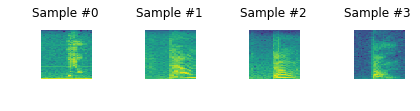

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt

imagesToShow=4

for i, data in enumerate(train_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

# The NN model

- We will use a several CNNs with conv(3x3) -> bn -> relu -> pool(4x4) -> fc.

- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

- `__init__: constructor. Create layers here. Note that we don't define the connections between layers in this function.`


- `forward(x): forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.` 

In [201]:
dropout = torch.nn.Dropout(p=0.30)
class ConvRes(nn.Module):
    def __init__(self, insize, outsize):
        super(ConvRes, self).__init__()
        drate = .3
        self.math = nn.Sequential(
            nn.BatchNorm2d(insize),
            # nn.Dropout(drate),
            torch.nn.Conv2d(insize, outsize, kernel_size=2, padding=2),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.math(x)


class ConvCNN(nn.Module):
    def __init__(self, insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
        super(ConvCNN, self).__init__()
        self.avg = avg
        self.math = torch.nn.Sequential(
            torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(outsize),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(pool, pool),
        )
        self.avgpool = torch.nn.AvgPool2d(pool, pool)

    def forward(self, x):
        x = self.math(x)
        if self.avg is True:
            x = self.avgpool(x)
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.cnn1 = ConvCNN(3, 32, kernel_size=7, pool=4, avg=False)
        self.cnn2 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)

        self.res1 = ConvRes(32, 64)

        self.features = nn.Sequential(
            self.cnn1, dropout,
            self.cnn2,
            self.cnn3,
            self.res1,
        )

        self.classifier = torch.nn.Sequential(
            nn.Linear(3136, 1),
        )
        self.sig = nn.Sigmoid()
  
    def forward(self, x):
        x = self.features(x)
#         print (x.data.shape)
        x = x.view(x.size(0), -1)
#         print (x.data.shape)
        x = self.classifier(x)
#         print (x.data.shape)
        x = self.sig(x)
        return x

    
if use_cuda:
    lgr.info ("Using the GPU")
    model = Net().cuda() # On GPU
else:
    lgr.info ("Using the CPU")
    model = Net() # On CPU

lgr.info('Model {}'.format(model))



INFO:__main__:Using the GPU
INFO:__main__:Model Net (
  (avgpool): AdaptiveAvgPool2d (output_size=1)
  (cnn1): ConvCNN (
    (math): Sequential (
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU (0.01)
      (3): MaxPool2d (size=(4, 4), stride=(4, 4), dilation=(1, 1))
    )
    (avgpool): AvgPool2d (size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn2): ConvCNN (
    (math): Sequential (
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU (0.01)
      (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (avgpool): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn3): ConvCNN (
    (math): Sequential (
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  

#  Loss and Optimizer

- Select a loss function and the optimization algorithm.

In [202]:
loss_func=torch.nn.BCELoss()
loss_func = nn.MultiLabelSoftMarginLoss()
# loss_func = torch.nn.CrossEntropyLoss()
# NN params
LR = 0.005
MOMENTUM= 0.9
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=5e-5) #  L2 regularization
if use_cuda:
    lgr.info ("Using the GPU")    
    model.cuda()
    loss_func.cuda()

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:Using the GPU
INFO:__main__:<torch.optim.adam.Adam object at 0x000001D7CB34D630>
INFO:__main__:MultiLabelSoftMarginLoss (
)


# Start training in Batches

See example here:
http://codegists.com/snippet/python/pytorch_mnistpy_kernelmode_python

https://github.com/pytorch/examples/blob/53f25e0d0e2710878449900e1e61d31d34b63a9d/mnist/main.py

Epoch 1


INFO:__main__:Train Epoch: 1 [0/21076 (0%)]	Loss: 0.660719
INFO:__main__:Train Epoch: 1 [1600/21076 (8%)]	Loss: 0.387869
INFO:__main__:Train Epoch: 1 [3200/21076 (15%)]	Loss: 0.380889
INFO:__main__:Train Epoch: 1 [4800/21076 (23%)]	Loss: 0.382154
INFO:__main__:Train Epoch: 1 [6400/21076 (30%)]	Loss: 0.381655
INFO:__main__:Train Epoch: 1 [8000/21076 (38%)]	Loss: 0.381613
INFO:__main__:Train Epoch: 1 [9600/21076 (46%)]	Loss: 0.381652
INFO:__main__:Train Epoch: 1 [11200/21076 (53%)]	Loss: 0.381373
INFO:__main__:Train Epoch: 1 [12800/21076 (61%)]	Loss: 0.380879
INFO:__main__:Train Epoch: 1 [14400/21076 (68%)]	Loss: 0.368087
INFO:__main__:Train Epoch: 1 [16000/21076 (76%)]	Loss: 0.381020
INFO:__main__:Train Epoch: 1 [17600/21076 (83%)]	Loss: 0.380616
INFO:__main__:Train Epoch: 1 [19200/21076 (91%)]	Loss: 0.380649
INFO:__main__:Train Epoch: 1 [20800/21076 (99%)]	Loss: 0.380856


Epoch 2


INFO:__main__:Train Epoch: 2 [0/21076 (0%)]	Loss: 0.384842
INFO:__main__:Train Epoch: 2 [1600/21076 (8%)]	Loss: 0.382288
INFO:__main__:Train Epoch: 2 [3200/21076 (15%)]	Loss: 0.380787
INFO:__main__:Train Epoch: 2 [4800/21076 (23%)]	Loss: 0.381129
INFO:__main__:Train Epoch: 2 [6400/21076 (30%)]	Loss: 0.380467
INFO:__main__:Train Epoch: 2 [8000/21076 (38%)]	Loss: 0.380020
INFO:__main__:Train Epoch: 2 [9600/21076 (46%)]	Loss: 0.380397
INFO:__main__:Train Epoch: 2 [11200/21076 (53%)]	Loss: 0.380416
INFO:__main__:Train Epoch: 2 [12800/21076 (61%)]	Loss: 0.380399
INFO:__main__:Train Epoch: 2 [14400/21076 (68%)]	Loss: 0.380360
INFO:__main__:Train Epoch: 2 [16000/21076 (76%)]	Loss: 0.380539
INFO:__main__:Train Epoch: 2 [17600/21076 (83%)]	Loss: 0.380192
INFO:__main__:Train Epoch: 2 [19200/21076 (91%)]	Loss: 0.380295
INFO:__main__:Train Epoch: 2 [20800/21076 (99%)]	Loss: 0.380580


Epoch 3


INFO:__main__:Train Epoch: 3 [0/21076 (0%)]	Loss: 0.382088
INFO:__main__:Train Epoch: 3 [1600/21076 (8%)]	Loss: 0.380348
INFO:__main__:Train Epoch: 3 [3200/21076 (15%)]	Loss: 0.380432
INFO:__main__:Train Epoch: 3 [4800/21076 (23%)]	Loss: 0.380840
INFO:__main__:Train Epoch: 3 [6400/21076 (30%)]	Loss: 0.380383
INFO:__main__:Train Epoch: 3 [8000/21076 (38%)]	Loss: 0.380638
INFO:__main__:Train Epoch: 3 [9600/21076 (46%)]	Loss: 0.380375
INFO:__main__:Train Epoch: 3 [11200/21076 (53%)]	Loss: 0.380404
INFO:__main__:Train Epoch: 3 [12800/21076 (61%)]	Loss: 0.380396
INFO:__main__:Train Epoch: 3 [14400/21076 (68%)]	Loss: 0.380356
INFO:__main__:Train Epoch: 3 [16000/21076 (76%)]	Loss: 0.380327
INFO:__main__:Train Epoch: 3 [17600/21076 (83%)]	Loss: 0.380345
INFO:__main__:Train Epoch: 3 [19200/21076 (91%)]	Loss: 0.380350
INFO:__main__:Train Epoch: 3 [20800/21076 (99%)]	Loss: 0.380327


Epoch 4


INFO:__main__:Train Epoch: 4 [0/21076 (0%)]	Loss: 0.381658
INFO:__main__:Train Epoch: 4 [1600/21076 (8%)]	Loss: 0.380393
INFO:__main__:Train Epoch: 4 [3200/21076 (15%)]	Loss: 0.384536
INFO:__main__:Train Epoch: 4 [4800/21076 (23%)]	Loss: 0.380313
INFO:__main__:Train Epoch: 4 [6400/21076 (30%)]	Loss: 0.380320
INFO:__main__:Train Epoch: 4 [8000/21076 (38%)]	Loss: 0.380328
INFO:__main__:Train Epoch: 4 [9600/21076 (46%)]	Loss: 0.380326
INFO:__main__:Train Epoch: 4 [11200/21076 (53%)]	Loss: 0.380332
INFO:__main__:Train Epoch: 4 [12800/21076 (61%)]	Loss: 0.380340
INFO:__main__:Train Epoch: 4 [14400/21076 (68%)]	Loss: 0.380334
INFO:__main__:Train Epoch: 4 [16000/21076 (76%)]	Loss: 0.380366
INFO:__main__:Train Epoch: 4 [17600/21076 (83%)]	Loss: 0.380299
INFO:__main__:Train Epoch: 4 [19200/21076 (91%)]	Loss: 0.380178
INFO:__main__:Train Epoch: 4 [20800/21076 (99%)]	Loss: 0.380448


GPU: 295.395 seconds


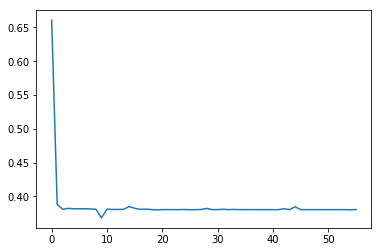

In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
 

    
clf=model 
opt= optimizer
loss_history = []
acc_history = []
 
def train(epoch):
    clf.train() # set model in training mode (need this because of dropout)
     
    # dataset API gives us pythonic batching 
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target) # RuntimeError: expected CPU tensor (got CUDA tensor)                           
                 
        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = clf(data)
        if use_cuda:
            loss = F.binary_cross_entropy(preds, target).cuda()
#             loss = F.log_softmax(preds).cuda() # TypeError: log_softmax() takes exactly 1 argument (2 given)
#             loss = F.nll_loss(preds, target).cuda() # https://github.com/torch/cutorch/issues/227
            
        else:
            loss = F.binary_cross_entropy(preds, target)
#             loss = F.log_softmax(preds)
#             loss = F.nll_loss(preds, target.long()) # RuntimeError: multi-target not supported at /pytorch/torch/lib/THNN/generic/ClassNLLCriterion.c:22
        loss.backward()
        
        opt.step()
        
        
        if batch_idx % 100 == 0:
            loss_history.append(loss.data[0])
            lgr.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))              

            
start_time = time.time()    

for epoch in range(1, 5):
    print("Epoch %d" % epoch)
    train(epoch)    
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

In [204]:
criterion = loss_func
all_losses = []
val_losses = []


if __name__ == '__main__':

    for epoch in range(global_epoches):
        print('Epoch {}'.format(epoch + 1))
        print('*' * 5 + ':')
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(train_loader, 1):
    
            img, label = data
            if use_cuda:
                img, label = Variable(img.cuda(async=True)), Variable(label.cuda(async=True))  # On GPU
            else:
                img, label = Variable(img), Variable(
                    label)  # RuntimeError: expected CPU tensor (got CUDA tensor)
    
            out = model(img)
            loss = criterion(out, label)
            running_loss += loss.data[0] * label.size(0)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if i % 100 == 0:
                all_losses.append(running_loss / (batch_size * i))
                print('[{}/{}] Loss: {:.6f}'.format(
                    epoch + 1, global_epoches, running_loss / (batch_size * i),
                    running_acc / (batch_size * i)))
                
    
#                 loss_cost = loss.data[0]                                
#                 # RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). 
#                 # Use .cpu() to move the tensor to host memory first.        
#                 prediction = (model(img).data).float() # probabilities         
#         #         prediction = (net(X_tensor).data > 0.5).float() # zero or one
#         #         print ("Pred:" + str (prediction)) # Pred:Variable containing: 0 or 1
#         #         pred_y = prediction.data.numpy().squeeze()            
#                 pred_y = prediction.cpu().numpy().squeeze()
#                 target_y = label.cpu().data.numpy()

#                 tu = (log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
#                 print ('LOG_LOSS={}, ROC_AUC={} '.format(*tu))  
        
    
        print('Finish {} epoch, Loss: {:.6f}'.format(epoch + 1, running_loss / (len(train_ds))))
    
        model.eval()
        eval_loss = 0
        eval_acc = 0
        for data in val_loader:
            img, label = data
    
            if use_cuda:
                img, label = Variable(img.cuda(async=True), volatile=True),Variable(label.cuda(async=True), volatile=True)  # On GPU
            else:
                img = Variable(img, volatile=True)
                label = Variable(label, volatile=True)
    
            out = model(img)
            loss = criterion(out, label)
            eval_loss += loss.data[0] * label.size(0)
    
        print('VALIDATION Loss: {:.6f}'.format(eval_loss / (len(val_ds))))
        val_losses.append(eval_loss / (len(val_ds)))
        print()
    

Epoch 1
*****:
[1/10] Loss: 0.694946
[1/10] Loss: 0.694047
[1/10] Loss: 0.693747
[1/10] Loss: 0.693598
[1/10] Loss: 0.693508
[1/10] Loss: 0.693449
[1/10] Loss: 0.693407
[1/10] Loss: 0.693376
[1/10] Loss: 0.693351
[1/10] Loss: 0.693331
[1/10] Loss: 0.693315
[1/10] Loss: 0.693302
[1/10] Loss: 0.693291
Finish 1 epoch, Loss: 0.693289
VALIDATION Loss: 0.693160

Epoch 2
*****:
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
[2/10] Loss: 0.693147
Finish 2 epoch, Loss: 0.693147
VALIDATION Loss: 0.693147

Epoch 3
*****:
[3/10] Loss: 0.693147
[3/10] Loss: 0.693147
[3/10] Loss: 0.693147


KeyboardInterrupt: 

In [ ]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=py09.html \
    './09 PyTorch Kaggle Image Data-set loading with CNN'